# Hate Speech Classification with a Long-Short Term Memory Model

This notebook utilises a Long-Short Term Memory (LSTM) model to determine if a tweet is `hateful` or `not hateful`.
<br>
<br>
A LSTM model is an improvement on the traditional RNN architecture, able to capture long-term dependencies in sequences by maintaining a constant representation of the features while adding or removing elements from it. The module is able to retain information longer than the solely sequential  method of a RNN and curb vanishing/exploding gradients.

## Imports

In [6]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch import nn
from collections import Counter
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
import numpy as np
import time
from wordcloud import WordCloud
import wandb
import preprocess
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
import graphviz
graphviz.set_jupyter_format('png')
import json
import display_details
import matplotlib.pyplot as plt

## Data PreProcessing

This cell is used to standardise and reduce datasets to `label` and `text` columns. 
<br>
They are then concatenated to form one large dataset.

Data sources:
- https://kaggle.com/datasets/kazanova/
- https://hasocfire.github.io/hasoc/2021/dataset.html
- https://figshare.com/articles/dataset/Labelled_Hate_Speech_Detection_Dataset_/19686954
- https://zenodo.org/record/3706866
- https://kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset
- https://kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset

In [2]:
df = pd.read_csv(
    'Data/Unprocessed/training.1600000.processed.noemoticon.csv', 
    encoding='latin', 
    header=None
    )
df.columns = ['label', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(columns=['id', 'date', 'query', 'user_id'])

df['label'].mask(df['label'] == 0, 1, inplace=True)
df['label'].mask(df['label'] == 2, 0, inplace=True)
df['label'].mask(df['label'] == 4, 0, inplace=True)

df_2 = pd.read_csv(
    'Data/Unprocessed/hasoc_english_dataset.tsv', 
    delimiter='\t'
    )
df_2 = df_2.drop(columns=['text_id', 'task_1', 'task_3'])
df_2 = df_2.rename(columns={'task_2': 'label'})

df_2['label'].mask(df_2['label'] == 'HATE', 1, inplace=True)
df_2['label'].mask(df_2['label'] == 'OFFN', 1, inplace=True)
df_2['label'].mask(df_2['label'] == 'PRFN', 1, inplace=True)
df_2['label'].mask(df_2['label'] == 'NONE', 0, inplace=True)

df_3 = pd.read_csv('Data/Unprocessed/HateSpeechDetection.csv')
df_3 = df_3.drop(columns=['Platform'])
df_3 = df_3.rename(columns={'Comment': 'text'})
df_3 = df_3.rename(columns={'Hateful': 'label'})

df_4 = pd.read_csv(
    'Data/Unprocessed/hatespeech_text_label_vote_RESTRICTED_100K.csv'
    )
df_4 = df_4.drop(columns=['Votes for the majority label'])
df_4 = df_4.rename(columns={'Tweet text': 'text'})
df_4 = df_4.rename(columns={'Label': 'label'})

df_4['label'].mask(df_4['label'] == 'normal', 0, inplace=True)
df_4['label'].mask(df_4['label'] == 'spam', 0, inplace=True)
df_4['label'].mask(df_4['label'] == 'abusive', 1, inplace=True)
df_4['label'].mask(df_4['label'] == 'hateful', 1, inplace=True)
df_4['text'] = df_4['text'].str.replace('RT', '')

df_5 = pd.read_csv('Data/Unprocessed/FinalBalancedDataset.csv')
df_5.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
df_5.drop(["a"], axis=1, inplace=True)
df_5 = df_5.rename(columns={'Toxicity': 'label'})
df_5 = df_5.rename(columns={'tweet': 'text'})
df_5['text'] = df_5['text'].str.replace('ð', '')

df_6 = pd.read_csv('Data/Unprocessed/Reddit_Data.csv')
df_6 = df_6.rename(columns={'clean_comment': 'text'})
df_6 = df_6.rename(columns={'category': 'label'})
df_6.drop(df_6[df_6['label'] == 0].index, inplace=True)
df_6 = df_6[df_6['text'] != '']
df_6['label'].mask(df_6['label'] == 1, 0, inplace=True)
df_6['label'].mask(df_6['label'] == -1, 1, inplace=True)

"""
Concatenate datasets
"""

processed_data = pd.concat([df, df_2, df_3, df_4, df_5, df_6])

processed_data['text'] = processed_data['text'].str.replace('https', '')
processed_data['text'] = processed_data['text'].str.replace('t', '')
processed_data['text'] = processed_data['text'].str.replace('co', '')
processed_data['text'] = processed_data['text'].str.replace('amp', '')
processed_data['text'] = processed_data['text'].str.replace('quo', '')

# save all data
processed_data.to_csv('Data/processed_data.csv')
print("{:,} elements".format(len(processed_data)))
processed_data.head()

1,789,694 elements


,label,text
0,1,"@swichfoo hp://wipic.m/2y1zl - Awww, ha's a bu..."
1,1,is upse ha he can' updae his Facebook by exing...
2,1,@Kenichan I dived many imes for he ball. Manag...
3,1,my whole body feels ichy and like is on fire
4,1,"@naionwideclass no, i's no behaving a all. i'm..."


## Word Clouds

(-0.5, 399.5, 299.5, -0.5)

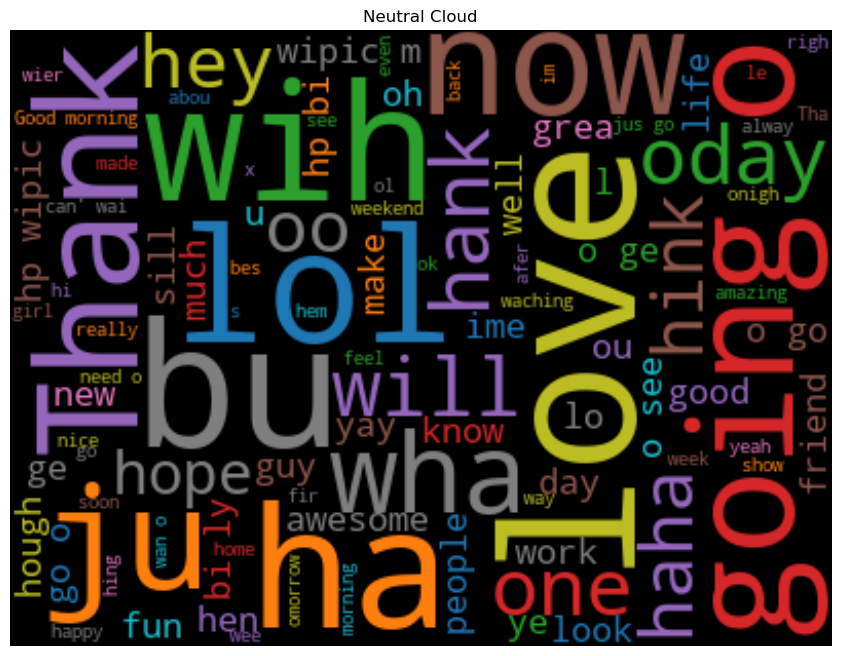

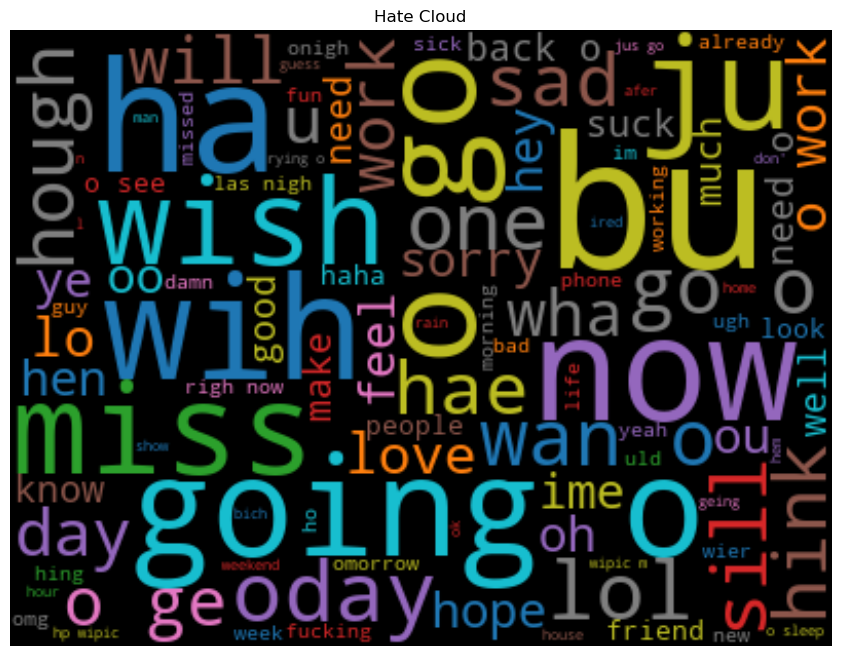

In [7]:
neutral_words = ' '.join([
    word for word in processed_data['text'][processed_data['label'] == 0]
    ])

neutral_cloud = WordCloud(background_color='black', 
                          colormap='tab10', 
                          contour_width=2, 
                          contour_color='white', 
                          width=400, 
                          height=300, 
                          max_font_size=90, 
                          max_words=100).generate(neutral_words)

plt.figure(figsize=(12, 8))
plt.imshow(neutral_cloud, interpolation='bilinear')
plt.title('Neutral Cloud')
plt.axis('off')

hate_words = ' '.join([
    word for word in processed_data['text'][processed_data['label'] == 1]
    ])

hate_cloud = WordCloud(background_color='black', 
                          colormap='tab10', 
                          contour_width=2, 
                          contour_color='white', 
                          width=400, 
                          height=300, 
                          max_font_size=90, 
                          max_words=100).generate(hate_words)

plt.figure(figsize=(12, 8))
plt.imshow(hate_cloud, interpolation='bilinear')
plt.title('Hate Cloud')
plt.axis('off')

## Create Subsets

The total dataset is very large, containing 1,789,694 items.
<br>
The dataset is split into subsets, each composed of a training, validation and test set. By treating these subsets as independent datasets, the model can be trained periodically.

In [8]:
def train_val_test_split(data):
    """
    Splits a dataset into train/val/test sets.
    
    - 81% Training data
    - 9% Validation data
    - 10% Testing data

    Args:
        data (DataFrame): DataFrame which needs splitting.

    Returns:
        train_data, val_data, test_data 
            (DataFrame, DataFrame, DataFrame): train/va/test sets.
    """
    train_data_ = data.sample(frac=0.9)
    test_data = data.drop(train_data_.index)
    train_data = train_data_.sample(frac=0.9)
    val_data = train_data_.drop(train_data.index)
    return train_data, val_data, test_data

def dataset_details(dataset, data_name, set_name):
    """
    Displays the number of elements each class has in the dataset.

    Args:
        dataset (DataFrame): 
        data_name (str): Name of the folder e.g. 'data_1'
        set_name (str): Name of the dataset (e.g. 'Training').
    """
    num_samples = len(dataset)
    num_label_0 = Counter(dataset['label'].tolist())[0]
    num_label_1 = Counter(dataset['label'].tolist())[1]
    split_percent = num_label_1 / num_samples * 100
    print('*' + '-' * 19 + '*')
    print(f'|      {data_name:11}  |')
    print(f'|     {set_name:11}   |')
    print('|' + '-' * 19 + '|')
    print(f'| Samples : {num_samples:7} |')
    print('*' + '-' * 19 + '*')
    print(f'| Neutral : {num_label_0:6}  |')
    print(f'| Hate    : {num_label_1:6}  |')
    print(f'| Split   : {split_percent:.2f}%  |')
    print('*' + '-' * 19 + '*')
    if set_name == 'Testing':
        print('\n\n')

In [9]:
# Shuffle dataframe
processed_data = processed_data.sample(frac=1)
# Split dataframe into subsets
num_subsets = 16
split_data = np.array_split(processed_data, num_subsets)
# List of subset names
data_names = ['data_1', 'data_2', 'data_3', 'data_4', 'data_5', 
    'data_6', 'data_7', 'data_8', 'data_9', 'data_10', 'data_11',
    'data_12', 'data_13', 'data_14', 'data_15', 'data_16']

"""
Iterates through the subsets and saves them to disk
Creates a training, validation and test set from each subset
Displays the label splits and saves each dataset to disk
"""
for i in range(len(split_data)):
    # reset indexes of each subset and save to disk
    split_data[i].reset_index(drop=True, inplace=True)
    split_data[i].to_csv(f'Data/Split Datasets/{data_names[i]}.csv')

    # Split subset into training, validation and test sets and save
    train, val, test = train_val_test_split(split_data[i])
    dataset_details(train, data_name=data_names[i], set_name='Training')
    dataset_details(val, data_name=data_names[i], set_name='Validation')
    dataset_details(test, data_name=data_names[i], set_name='Testing')
    train.to_csv(f'Data/Split Datasets/{data_names[i]}/train.csv')
    val.to_csv(f'Data/Split Datasets/{data_names[i]}/val.csv')
    test.to_csv(f'Data/Split Datasets/{data_names[i]}/test.csv')

*-------------------*
|      data_1       |
|     Training      |
|-------------------|
| Samples :   90603 |
*-------------------*
| Neutral :  46510  |
| Hate    :  44093  |
| Split   : 48.67%  |
*-------------------*
*-------------------*
|      data_1       |
|     Validation    |
|-------------------|
| Samples :   10067 |
*-------------------*
| Neutral :   5243  |
| Hate    :   4824  |
| Split   : 47.92%  |
*-------------------*
*-------------------*
|      data_1       |
|     Testing       |
|-------------------|
| Samples :   11186 |
*-------------------*
| Neutral :   5731  |
| Hate    :   5455  |
| Split   : 48.77%  |
*-------------------*



*-------------------*
|      data_2       |
|     Training      |
|-------------------|
| Samples :   90603 |
*-------------------*
| Neutral :  46889  |
| Hate    :  43714  |
| Split   : 48.25%  |
*-------------------*
*-------------------*
|      data_2       |
|     Validation    |
|-------------------|
| Samples :   10067 |
*------

## Build Vocabulary

A vocabulary is built by counting the occurences of words in the entire dataset and mapping them to the number of occurences.

In [10]:
def build_vocab(data, max_size=30000):
    """
    Uses a Counter object to count occurences of words.
    Maps the word to the number of occurences.

    Args:
        data (dataset): Dataset containing all words.
        max_size (int, optional): Maximum size of vocab. (default=30000)

    Returns:
        v (Vocab): Vocabulary object of max_size words
    """
    tokenizer = get_tokenizer('basic_english')
    counter = Counter()
    for(label, text) in data:
        counter.update(tokenizer(text))
    most_common = counter.most_common(max_size)
    counter = Counter(dict(most_common))
    v = Vocab(counter)
    return v

# Load dataset
processed_data = pd.read_csv(
    'Data/processed_data.csv'
    ).drop(columns=['Unnamed: 0'])

processed_data = processed_data.to_numpy()

vocab = build_vocab(processed_data)
# Save vocab so it can be used for subsequent training runs
with open('Data/vocab.json', 'w') as f:
    json.dump(vocab.stoi, f)
data_pipeline = preprocess.PreprocessingPipeline(vocab)

## Collate Batches and Initialise DataLoaders

Collates `label`/`text` pairs into tuples and transforms the text to its vocabulary representation.
Pads batches to the same length by repeating the last element.

Called by DataLoaders.


In [11]:
def collate_batch(batch, pipeline, device):
    """
    Custom collate function to prepare batches for LSTM processing.
    Ensures the label is an integer and transforms the input sequence
        to its integer representation.
    
    Args:
        batch (numpy.array): List of tuples containing label/text pairs.
        embeddings (dict): Dictionary of word/int embedding pairs.
        dimensions (int): Dimensions used for embedding vector.
        pipeline (preprocess.PreprocessingPipeline): Data pipeline.
        device (torch.device): Device used to process tensors.

    Returns:
        label_list, text_list, text_lengths 
        (torch.Tensor, torch.Tensor, torch.Tensor): 
            Tensors of labels, padded embeddings and text lengths.
    """
    labels, texts, text_lengths = [], [], []
    for(label, text) in batch:
        l, t = pipeline.label_text_preprocess(label, text)
        labels.append(l)
        texts.append(torch.tensor(t, dtype=torch.int64))
        text_lengths.append(len(t))

    labels = torch.tensor(labels, dtype=torch.int64)
    texts = rnn_utils.pad_sequence(texts, batch_first=True, padding_value=0)
    text_lengths = torch.tensor(text_lengths, dtype=torch.int64)
    return labels.to(device), texts.to(device), text_lengths.to(device)        



def batch_padding(batch_size, pipeline, device):
    """
    Pads batches to specified size then processes using `collate_fn()`. 
    Pads by repeating the last element until batch_size is reached.

    Args:
        batch_size (int): The size of each batch.
    
    Returns:
        collate_fn (function): Function to pad a batch and 
            processes it `collage_batch()`
    """
    def collate_fn(batch):
        padded_batch = batch + [batch[-1]] * (batch_size - len(batch))
        return collate_batch(padded_batch, pipeline, device)
    return collate_fn

## Initialise DataLoaders

In [12]:
def set_device():
    """
    Device used to process tensors.
    """
    if torch.backends.mps.is_available():
        if torch.backends.mps.is_built():
            print('Using MPS')
            return torch.device("mps")
    else:
        return torch.device("cpu")

def init_dataloaders(folder, 
                     batch_size, 
                     pipeline,
                     device):
    """
    Creates train/val/test DataLoaders.

    Args:
        folder (str): train/val/test csv within 'Data/Split Datasets/'. 
        embedding_dict (dict): word/GloVe embeddings
        batch_size (int): Batch size
        dimensions (int): Dimensions of data. Used for padding batches.
        device (torch.device): Device used to process data.

    Returns:
        train_loader, val_loader, test_loader
            (DataLoader, DataLoader, DataLoader): Required DataLoaders.
    """
    train = pd.read_csv(
        f'Data/Split Datasets/{folder}/train.csv'
        ).drop(columns=['Unnamed: 0'])
    val = pd.read_csv(
        f'Data/Split Datasets/{folder}/val.csv'
        ).drop(columns=['Unnamed: 0'])
    test = pd.read_csv(
        f'Data/Split Datasets/{folder}/test.csv'
        ).drop(columns=['Unnamed: 0'])

    train = train.to_numpy()
    val = val.to_numpy()
    test = test.to_numpy()

    train_loader = DataLoader(
        train, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=batch_padding(batch_size, pipeline, device)
        )
        
    val_loader = DataLoader(
        val, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=batch_padding(batch_size, pipeline, device)
        )

    test_loader = DataLoader(
        test, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=batch_padding(batch_size, pipeline, device)
        )

    return train_loader, val_loader, test_loader

## Training

`train()` is used to train the model for a specified number of epochs. 
<br>
`evaluate()` runs through either validation or test data and does not perform backpropagation. The model cannot learn from evaluation data.
<br>
<br>
Both functions are wrapped in `model_env()` making it easy to complete training and evaluation sequence.

In [13]:
def train(dataloader, 
          model, 
          optimizer, 
          scheduler, 
          criterion, 
          verbose=True):
    """
    Used to train a neural network.
    Sets the model to training mode and initialises variables to keep 
    track of metrics during training.
    Iterates through label/text pairs from each dataset making label
    predictions. 
    Calculates loss and backpropagates parameter updates
    through the network to ideally reduce loss over epochs.

    Args:
        dataloader (DataLoader): DataLoader containing training
            data.
        model (nn.Module): The LSTM model being trained.
        optimizer (torch.optim.Adam): Backpropagation method.
        criterion (torch.nn.modules.loss): Loss function.
        verbose (bool): Display metrics (default=True).

    Returns:
        epoch_loss, epoch_accuracy, epoch_count 
            (float, float): normalised loss and normalised accuracy.
    """
    model.train()
    # Accuracy and loss accumulated over epoch
    total_accuracy, total_loss = 0, 0
    # Number of predictions
    num_predictions = 0
    # Displays training metrics every quarter of epoch
    intervals = (len(dataloader) / 4).__round__()
    for idx, (label, text, text_lengths) in enumerate(dataloader):
        # Make prediction
        prediction = model(text, text_lengths)
        label = label.unsqueeze(1)
        # Calculate loss
        loss = criterion(prediction, label.float())
        batch_loss = loss.item()
        # Update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Store metrics
        total_accuracy += ((prediction > 0.5) == label).sum().item()
        total_loss += batch_loss
        num_predictions += label.size(0)

        if verbose and idx % intervals == 0 and idx > 0:
            epoch_metrics = (
                f'| {idx:5} / {len(dataloader):5} batches |' 
                f' {(total_accuracy/num_predictions)*100:.8f}% accurate |'
                )
            print(epoch_metrics)
    scheduler.step()
    average_accuracy_pct = (total_accuracy / num_predictions) * 100
    average_loss_per_sample = total_loss / num_predictions
    return average_loss_per_sample, average_accuracy_pct

def evaluate(dataloader, model, criterion):
    """
    Used to evaluate model training.
    Works similarly to the training method, allowing the model
    to make predictions on labelled data, however no parameters are
    updated.

    Args:
        dataloader (DataLoader): DataLoader containing either validation
            or testing data.
        model (nn.Module): The LSTM model being trained.
        criterion (torch.nn.modules.loss): Loss function.

    Returns:
        batch_loss, batch_accuracy, batch_count 
            (float, float): normalised loss and normalised accuracy.
    """
    model.eval()
    total_accuracy = 0
    num_predictions = 0
    total_loss = 0
    with torch.no_grad():
        for idx, (label, text, text_length) in enumerate(dataloader):
            prediction = model(text, text_length)
            label = label.unsqueeze(1)
            loss = criterion(prediction, label.float())
            total_accuracy += ((prediction > 0.5) == label).sum().item()
            num_predictions += label.size(0)
            total_loss += loss.item()
    average_accuracy_pct = (total_accuracy / num_predictions) * 100
    average_loss_per_sample = total_loss / num_predictions
    return average_loss_per_sample, average_accuracy_pct

def model_env(training, 
              validation, 
              testing, 
              model, 
              optimizer,
              scheduler, 
              criterion, 
              epochs, 
              verbose=True,
              wandb_track=True):
    """
    Wraps the training and evaluation functions in one method.
    At the end of each epoch, the model asseses the validation set.
    Once all epochs are complete performance is assesed on the test set.

    Args:
        training (DataLoader): DataLoader with training data.
        validation (DataLoader): DataLoader with validation data.
        testing (DataLoader): DataLoader with testing data.
        model (nn.Module): The LSTM model being trained.
        optimizer (torch.optim.Adam): Backpropagation method.
        criterion (torch.nn.modules.loss): Loss function.
        epochs (int): Number of epochs the model is trained for.
        verbose (bool): Display metrics (default=True).
        wandb_track (bool): Track metrics with wandb (default=True).

    Returns:
        train_accuracy, train_loss, val_accuracy, val_loss 
            (list, list, list, list): Metrics saved during training and
            evaluation.
    """
    # Containers for training and evaluation metrics
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    # Time saved for calculating final processing time
    start_time = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()
        print('-' * 49)
        print(f'|\t\t     Epoch {epoch + 1}      \t\t|')
        print('-' * 49)
        # Process training data
        t_loss, t_acc = train(training, 
                                 model, 
                                 optimizer,
                                 scheduler, 
                                 criterion, 
                                 verbose)  
        # Store training metrics
        train_loss.append(t_loss)
        train_accuracy.append(t_acc)
        # Evaluate validation data
        v_loss, v_acc = evaluate(validation, model, criterion)
        # Store evaluation metrics
        val_loss.append(v_loss)
        val_accuracy.append(v_acc)
        # Log metrics to wandb

        print('-' * 49)
        print(f'| Validation Accuracy   : {v_acc:.8f}% accurate |')
        print('-' * 49)
        print(f'| Time Elapsed\t\t: {time.time() - epoch_start:.2f} seconds\t\t|')
        print('-' * 49)
        print()
        if wandb_track:
            wandb.log({
            'Epoch': epoch,
            'Training Accuracy': t_acc,
            'Training Loss': t_loss,
            'Validation Accuracy': v_acc, 
            'Validation Loss': v_loss,
            })

    # Assess model performance on test data
    _, test_acc = evaluate(testing, model, criterion)
    total_minutes = (time.time() - start_time).__round__()/60
    print('*' + '-' * 47 + '*')
    test_metrics = (
        f'*\t\tEvaluating Test Data\t\t*\n'
        f'*' + '-' * 47 + '*\n'
        f'* Test Accuracy\t\t: {test_acc:.8f}% accurate *\n'
        f'* Total Training Time\t: {total_minutes:.2f} minutes  \t*'
    )
    print(test_metrics)
    print('*' + '-' * 47 + '*')
    if wandb_track:
            wandb.finish()
    return train_accuracy, train_loss, val_accuracy, val_loss

## LSTM Model

In [14]:
class LSTM_Model(nn.Module):
    """
    LSTM model used to process and predict sentiment of
        a textual input sequence.
    Extracts data from an input sequence via LSTM modules before the 
        classifier determines an output.

    Args:
        nn (nn.Module): Base class for PyTorch neural networks.
    """
    def __init__(self, vocab_size, vector_dim, num_hidden_nodes, hidden_layers):
        """
        Initialises LSTM modules, the classifier, 
            batch normalisation, ReLU activation and dropout.

        Args:
            vocab_size (int): Size of the vocabulary. 
                Used to determine size of embedding layer.
            vector_dim (int): Dimensions of vector embeddings.
            num_hidden_nodes (int): Number of nodes in the LSTM module.
            hidden_layers (int): Number of hidden layers in the module.
        """
        super(LSTM_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_size, vector_dim)

        self.lstm1 = nn.LSTM(vector_dim,
                    num_hidden_nodes*2,
                    hidden_layers,
                    bidirectional=False,
                    dropout=0,
                    batch_first=True)

        self.lstm2 = nn.LSTM(num_hidden_nodes*2,
                    num_hidden_nodes*4,
                    hidden_layers,
                    bidirectional=False,
                    dropout=0,
                    batch_first=True)
        
        self.linear1 = nn.Linear(num_hidden_nodes*4, 32)
        self.linear1_batch_norm = nn.BatchNorm1d(32)

        self.linear2 = nn.Linear(32, 16)
        self.linear2_batch_norm = nn.BatchNorm1d(16)
        
        self.linear3 = nn.Linear(16, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, text, text_lengths):
        """
        Determines the order of operations in the model.
        Processes the text through LSTM modules and a classifier.

        Args:
            text (torch.Tensor): List of data.
            text_lengths (torch.Tensor): Tensor representing the length 
                of each text sequence in the batch. 
                Shape: [batch_size]

        Returns:
            x (torch.Tensor): The model's predictions. 
        """
        embeddings = self.embedding(text)
        x, _ = self.lstm1(embeddings)
        x, _ = self.lstm2(x)
        x = x[torch.arange(x.shape[0]), text_lengths-1, :]
        x = self.relu(self.dropout(self.linear1_batch_norm(self.linear1(x))))
        x = self.relu(self.dropout(self.linear2_batch_norm(self.linear2(x))))
        x = self.linear3(x)
        return x 

## Define Hyperparameters and Run Model

In [15]:
# ! These parameters must be the same when loading a model

vocab_len = len(vocab)

dimensions = 75
# Number of nodes in the LSTM module
hidden_nodes = 4
# Number of layers in the LSTM module
hidden_layers = 3
# Size of batches 
batch_size = 128
# Set device used to process tensors
device = set_device()

# Initialise DataLoaders from Data/Split Datasets/
train_loader, val_loader, test_loader = init_dataloaders(
    folder='data_1',
    batch_size=batch_size,
    pipeline=data_pipeline,
    device=device
    )

lstm = LSTM_Model(
    vocab_size=vocab_len,
    vector_dim=dimensions, 
    num_hidden_nodes=hidden_nodes, 
    hidden_layers=hidden_layers
    ).to(device)

learning_rate = 0.01
# Loss function
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=5,
                                      verbose=True)

params = sum(p.numel() for p in lstm.parameters())
params = "{:,}".format(params)
print(f"LSTM has {params} trainable parameters.")

Using MPS
Adjusting learning rate of group 0 to 1.0000e-02.
LSTM has 2,261,223 trainable parameters.


In [18]:
epochs = 5

# Toggle tracking with wandb
track = False

if track:
    wandb.init(
    project = "hate-speech-classification",
    config = {
        "learning rate": learning_rate,
        "architecture": "LSTM",
        "epochs": epochs,
    })

t_acc, t_loss, v_acc, v_loss = model_env(
    train_loader, 
    val_loader, 
    test_loader, 
    lstm, 
    optimizer,
    scheduler, 
    criterion, 
    epochs, 
    verbose=True,
    wandb_track=track
    )

-------------------------------------------------
|		     Epoch 1      		|
-------------------------------------------------
|   177 /   708 batches | 79.19153792% accurate |
|   354 /   708 batches | 79.21214789% accurate |
|   531 /   708 batches | 79.14414944% accurate |
Adjusting learning rate of group 0 to 1.0000e-02.
-------------------------------------------------
| Validation Accuracy   : 76.59216772% accurate |
-------------------------------------------------
| Time Elapsed		: 29.84 seconds		|
-------------------------------------------------

-------------------------------------------------
|		     Epoch 2      		|
-------------------------------------------------
|   177 /   708 batches | 83.66397472% accurate |
|   354 /   708 batches | 83.30325704% accurate |
|   531 /   708 batches | 82.85508694% accurate |
Adjusting learning rate of group 0 to 1.0000e-02.
-------------------------------------------------
| Validation Accuracy   : 76.41416139% accurate |
--------------

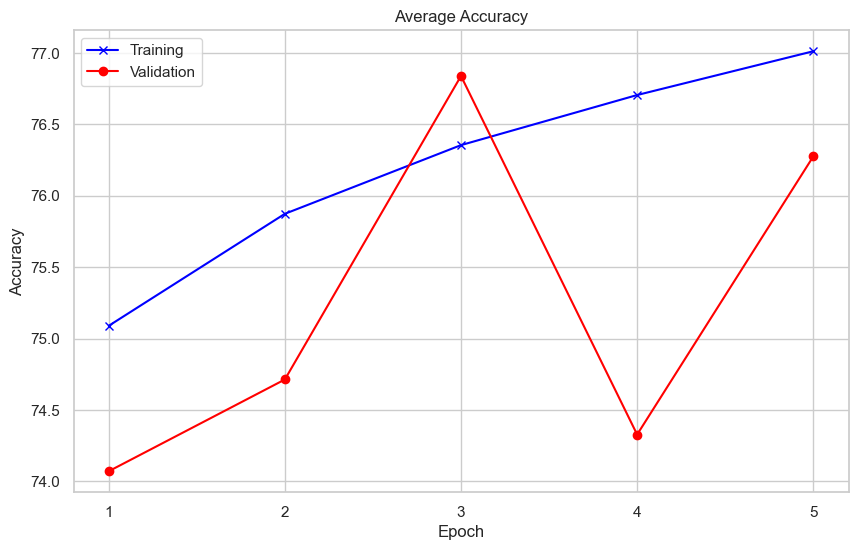

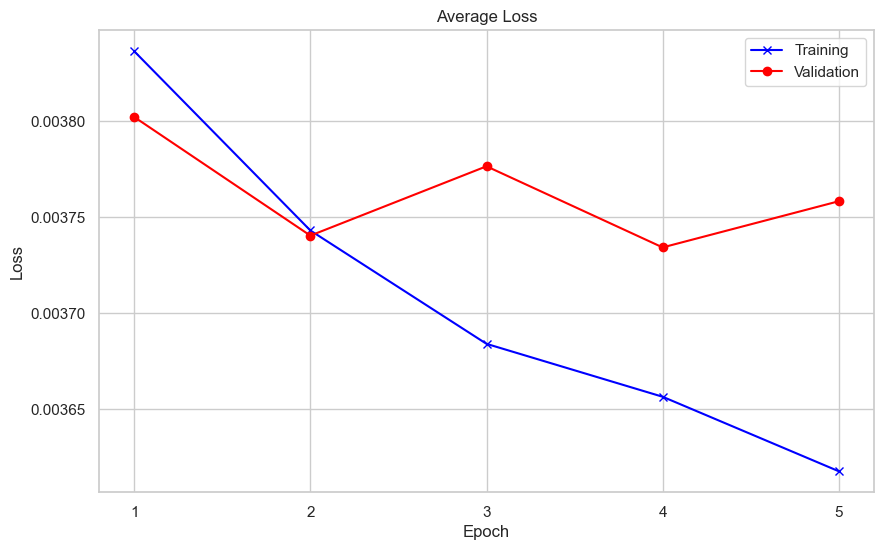

LSTM_Model(
  (embedding): Embedding(30002, 75)
  (lstm1): LSTM(75, 8, num_layers=3, batch_first=True)
  (lstm2): LSTM(8, 16, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=16, out_features=32, bias=True)
  (linear1_batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (linear2_batch_norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
) 

2260502 weights.
721 biases.

2261223 total trainable parameters, (weights + biases).


In [29]:
display = display_details.DisplayDetails()
display.plot_metrics(t_acc, v_acc, 'Accuracy')
display.plot_metrics(t_loss, v_loss, 'Loss')
display.print_model_details(lstm)


## Save Model

Saves the model and its state dictionary at a checkpoint. This allows the model to continue training in the future.

In [23]:
def save_model(model, model_optimizer):
    """
    Saves the model and optimizer state dictionaries.
    The model `state_dict` contains all learnable parameters of the model.
    The optimizer `state_dict` contains information about the optimizer.
        This allows the model to pause and resume training.
    Args:
        model (nn.Module): The LSTM model being loaded.
        model_optimizer (torch.optim.Adam): Backpropagation method.
    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': model_optimizer.state_dict(),
    }, 'checkpoint.pth')

save_model(lstm, optimizer)

## Load the Model

Load the model to resume training or make predictions.

In [26]:
def load_model():
    if torch.backends.mps.is_available():
        if torch.backends.mps.is_built():
            device = torch.device("mps")
            # ! These parameters must be the same as the saved model
            vocab_len = len(vocab)
            # Data dimensionality
            dimensions = 75
            # Number of nodes in the LSTM module
            hidden_nodes = 4
            # Number of layers in the LSTM module
            hidden_layers = 3
            lstm = LSTM_Model(
                vocab_size=vocab_len,
                vector_dim=dimensions, 
                num_hidden_nodes=hidden_nodes, 
                hidden_layers=hidden_layers
                ).to(device)
            return lstm
    else:
        raise ValueError('Model cannot train without MPS device\n')

loaded_model = load_model()

## Resume Training

In [27]:
epochs = 5
batch_size = 128
optimizer = optim.SGD(lstm.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                    step_size=8,
                                    gamma=0.8)

checkpoint = torch.load('checkpoint.pth')
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

"""
Model has currently been trained on:
☑ data_1
☐ data_2
...
☐ data_16
"""
# * Ensure this is the correct folder before training
data_folder = 'data_2'

train_loader, val_loader, test_loader = init_dataloaders(
    folder=data_folder,
    batch_size=batch_size,
    pipeline=data_pipeline,
    device=device
    )

t_acc, t_loss, v_acc, v_loss = model_env(
    train_loader, 
    val_loader, 
    test_loader, 
    lstm, 
    optimizer,
    scheduler, 
    criterion, 
    epochs, 
    verbose=True,
    wandb_track=track
    )

-------------------------------------------------
|		     Epoch 1      		|
-------------------------------------------------
|   177 /   708 batches | 74.96488764% accurate |
|   354 /   708 batches | 75.00880282% accurate |
|   531 /   708 batches | 75.10720160% accurate |
-------------------------------------------------
| Validation Accuracy   : 74.07041139% accurate |
-------------------------------------------------
| Time Elapsed		: 27.35 seconds		|
-------------------------------------------------

-------------------------------------------------
|		     Epoch 2      		|
-------------------------------------------------
|   177 /   708 batches | 75.57496489% accurate |
|   354 /   708 batches | 75.63160211% accurate |
|   531 /   708 batches | 75.76215930% accurate |
-------------------------------------------------
| Validation Accuracy   : 74.71321203% accurate |
-------------------------------------------------
| Time Elapsed		: 25.52 seconds		|
-----------------------------

<class 'display_details.DisplayDetails'>


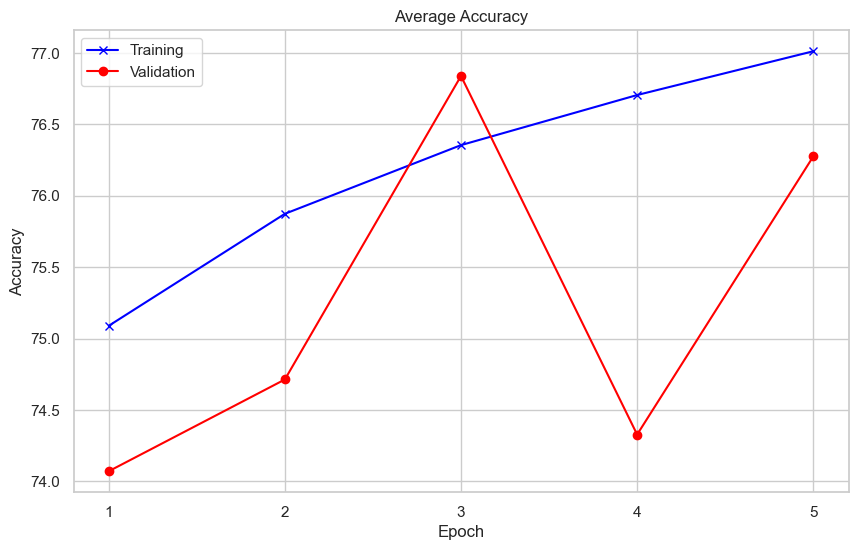

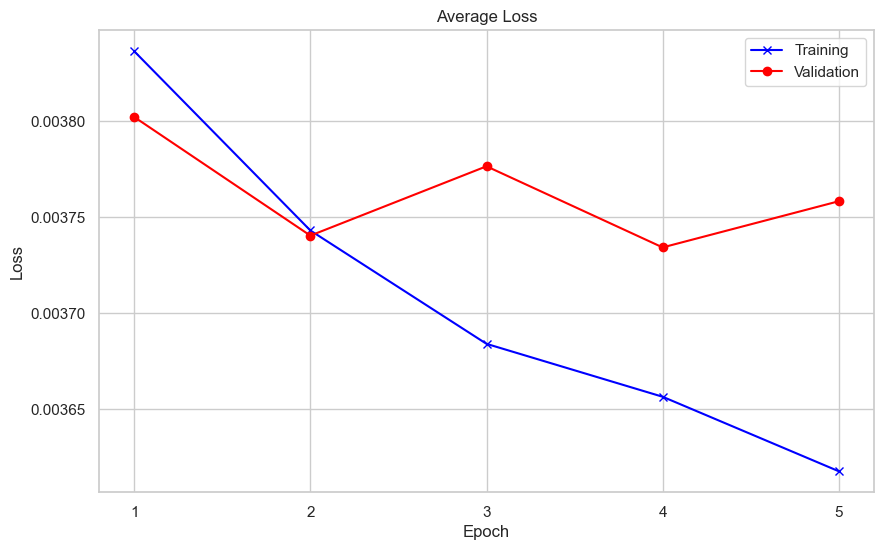

LSTM_Model(
  (embedding): Embedding(30002, 75)
  (lstm1): LSTM(75, 8, num_layers=3, batch_first=True)
  (lstm2): LSTM(8, 16, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=16, out_features=32, bias=True)
  (linear1_batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (linear2_batch_norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
) 

2260502 weights.
721 biases.

2261223 total trainable parameters, (weights + biases).


In [28]:
import display_details

display = display_details.DisplayDetails()
display.plot_metrics(t_acc, v_acc, 'Accuracy')
display.plot_metrics(t_loss, v_loss, 'Loss')
display.print_model_details(lstm)

In [ ]:
def save_model(model, model_optimizer):
    """
    Saves the model and optimizer state dictionaries.
    The model `state_dict` contains all learnable parameters of the model.
    The optimizer `state_dict` contains information about the optimizer.
        This allows the model to pause and resume training.
    Args:
        model (nn.Module): The LSTM model being loaded.
        model_optimizer (torch.optim.Adam): Backpropagation method.
    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': model_optimizer.state_dict(),
    }, 'checkpoint.pth')

save_model(loaded_model, optimizer)